Group Members: Asha Karmakar, Akhil Iyer, Megan Sundheim, Grace Kim

In [3]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import math

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from collections import Counter

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

<p> https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features </p>

<h1> Data Preprocessing & Exploration </h1>

In [4]:
# Read in csv file
df = pd.read_csv("./data/genres.csv")

/var/folders/9g/b2l7_2w96djf8mm1_xvcd7sr0000gn/T/ipykernel_44163/3599437126.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/genres.csv")


In [5]:
# Clean data
# Remove the following columns: type, id, uri, track_href, analysis_url, unnamed, title, song_name
df = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
         'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'genre']]

In [6]:
# One hot encode time signature
df = pd.get_dummies(df, columns=['time_signature'], drop_first=False)
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genre,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,0.831,0.814,2,-7.364,1,0.4200,0.059800,0.013400,0.0556,0.3890,156.985,124539,Dark Trap,False,False,True,False
1,0.719,0.493,8,-7.230,1,0.0794,0.401000,0.000000,0.1180,0.1240,115.080,224427,Dark Trap,False,False,True,False
2,0.850,0.893,5,-4.783,1,0.0623,0.013800,0.000004,0.3720,0.0391,218.050,98821,Dark Trap,False,False,True,False
3,0.476,0.781,0,-4.710,1,0.1030,0.023700,0.000000,0.1140,0.1750,186.948,123661,Dark Trap,False,True,False,False
4,0.798,0.624,2,-7.668,1,0.2930,0.217000,0.000000,0.1660,0.5910,147.988,123298,Dark Trap,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42300,0.528,0.693,4,-5.148,1,0.0304,0.031500,0.000345,0.1210,0.3940,150.013,269208,hardstyle,False,False,True,False
42301,0.517,0.768,0,-7.922,0,0.0479,0.022500,0.000018,0.2050,0.3830,149.928,210112,hardstyle,False,False,True,False
42302,0.361,0.821,8,-3.102,1,0.0505,0.026000,0.000242,0.3850,0.1240,154.935,234823,hardstyle,False,False,True,False
42303,0.477,0.921,6,-4.777,0,0.0392,0.000551,0.029600,0.0575,0.4880,150.042,323200,hardstyle,False,False,True,False


In [7]:
# Separate data into features and class labels
features = df.drop('genre', axis=1)
labels = df['genre']

In [8]:
print(features.head())
label_groups = df.groupby('genre')
print(label_groups.size())

   danceability  energy  key  loudness  mode  speechiness  acousticness   
0         0.831   0.814    2    -7.364     1       0.4200        0.0598  \
1         0.719   0.493    8    -7.230     1       0.0794        0.4010   
2         0.850   0.893    5    -4.783     1       0.0623        0.0138   
3         0.476   0.781    0    -4.710     1       0.1030        0.0237   
4         0.798   0.624    2    -7.668     1       0.2930        0.2170   

   instrumentalness  liveness  valence    tempo  duration_ms   
0          0.013400    0.0556   0.3890  156.985       124539  \
1          0.000000    0.1180   0.1240  115.080       224427   
2          0.000004    0.3720   0.0391  218.050        98821   
3          0.000000    0.1140   0.1750  186.948       123661   
4          0.000000    0.1660   0.5910  147.988       123298   

   time_signature_1  time_signature_3  time_signature_4  time_signature_5  
0             False             False              True             False  
1           

In [9]:
# There are no missing values
null_data = df[df.isnull().any(axis=1)]
len(null_data)

0

[Text(0.5, 0, 'danceability'),
 Text(1.5, 0, 'energy'),
 Text(2.5, 0, 'key'),
 Text(3.5, 0, 'loudness'),
 Text(4.5, 0, 'mode'),
 Text(5.5, 0, 'speechiness'),
 Text(6.5, 0, 'acousticness'),
 Text(7.5, 0, 'instrumentalness'),
 Text(8.5, 0, 'liveness'),
 Text(9.5, 0, 'valence'),
 Text(10.5, 0, 'tempo'),
 Text(11.5, 0, 'duration_ms'),
 Text(12.5, 0, 'time_signature_1'),
 Text(13.5, 0, 'time_signature_3'),
 Text(14.5, 0, 'time_signature_4'),
 Text(15.5, 0, 'time_signature_5')]

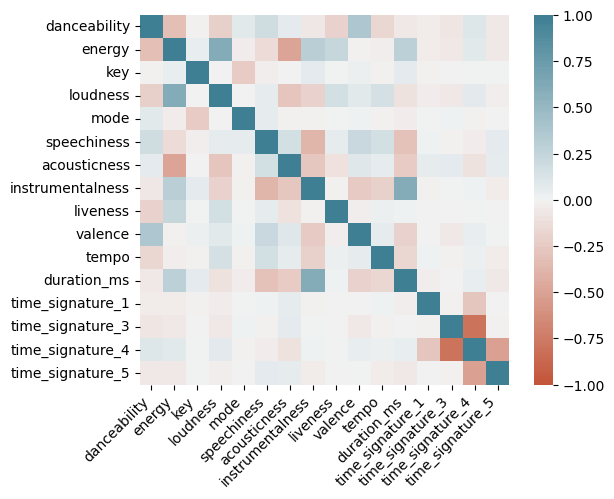

In [10]:
import seaborn as sns

# Correlation between features
ax = sns.heatmap(
    features.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [11]:
# Need to standardize for PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaled_data = StandardScaler().fit_transform(features.values)
music_data_scaled = pd.DataFrame(scaled_data, columns=features.columns)
music_data_scaled.head()

print("num features before PCA: ", len(features.columns))

pca = PCA(n_components=0.95, svd_solver='full')
pca_data = pca.fit_transform(music_data_scaled)
music_data_pca = pd.DataFrame(pca_data)
music_data_pca.head()

print("num features after PCA: ", len(music_data_pca.columns))

num features before PCA:  16
num features after PCA:  13


<h1> Model Building </h1>

In [33]:
def plot_confusion_matrix(confusion_mat):
    ax = plt.subplot()
    sns.heatmap(confusion_mat, annot=True, fmt='g', ax=ax)
    
    unique_labels = sorted(list(set(list(labels))))

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(unique_labels, rotation=90)
    ax.yaxis.set_ticklabels(unique_labels, rotation=0)

## Decision Tree

In [34]:
def decision_tree_clf(features, labels):
    dt_model = tree.DecisionTreeClassifier()
    parameters = {'criterion':["gini", "entropy"], 'max_depth':[5, 10, 15, 20], 'min_samples_leaf':[5, 10, 15, 20], 'max_features': [5, 10, 15]}
    dt_grid = GridSearchCV(dt_model, parameters, scoring="accuracy", cv=10)
    dt_grid.fit(features, labels)
    
    best_params = dt_grid.best_params_
    
    dt_model = tree.DecisionTreeClassifier(criterion=best_params.get("criterion"), max_depth=best_params.get("max_depth"), min_samples_leaf=best_params.get("min_samples_leaf"), max_features=best_params.get("max_features"))
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    dt_model = dt_model.fit(X_train, y_train)
    y_pred = dt_model.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    
    confusion_mat = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion_mat)

### Deleteing anomalies

In [35]:
def delete_anomalies(features, labels):
    features_no_anomalies = features.copy()
    labels_no_anomalies = labels.copy()
    anomaly_indices = set()
    
    y_pred_list = []
    envelope_pred = EllipticEnvelope().fit_predict(features)
    y_pred_list.append(envelope_pred)

    # Apply IsolationForest AD
    forest_pred = IsolationForest().fit_predict(features)
    y_pred_list.append(forest_pred)

    # Apply LocalOutlierFactor AD
    lof_pred = LocalOutlierFactor().fit_predict(features)
    y_pred_list.append(lof_pred)

    for arr in y_pred_list:
        c = Counter(arr)
        print(c)
        i = len(arr) - 1
        while i >= 0:
            if arr[i] == -1:
                anomaly_indices.add(i)
            i -= 1

    # Drop anomalies indicated by any of the 3 anomaly detection algorithms.
    anomaly_indices = list(anomaly_indices)
    anomaly_indices.sort()
    features_no_anomalies = features_no_anomalies.drop(anomaly_indices, axis=0)
    labels_no_anomalies = labels_no_anomalies.drop(anomaly_indices, axis=0)

    features_no_anomalies = features_no_anomalies.reset_index().drop('index', axis=1)
    labels_no_anomalies = labels_no_anomalies.reset_index().drop('index', axis=1)
    label_groups = labels_no_anomalies.groupby('genre')
    print("After removing anomalies", label_groups.size())
    
    return features_no_anomalies, labels_no_anomalies

In [36]:
# With anomalies
decision_tree_clf(features, labels)

# Without anomalies
features_no_anomalies, labels_no_anomalies = delete_anomalies(features, labels)
decision_tree_clf(features_no_anomalies, labels_no_anomalies)

                 precision    recall  f1-score   support

      Dark Trap       0.50      0.36      0.42       970
            Emo       0.57      0.51      0.54       341
         Hiphop       0.43      0.43      0.43       621
            Pop       0.38      0.08      0.13        98
            Rap       0.85      0.28      0.42       341
            RnB       0.30      0.33      0.31       396
     Trap Metal       0.37      0.21      0.27       384
Underground Rap       0.42      0.64      0.51      1192
            dnb       0.95      0.96      0.95       599
      hardstyle       0.80      0.80      0.80       619
      psytrance       0.89      0.86      0.88       598
      techhouse       0.85      0.85      0.85       568
         techno       0.80      0.81      0.80       590
         trance       0.74      0.83      0.78       562
           trap       0.70      0.77      0.74       582

       accuracy                           0.63      8461
      macro avg       0.64   

### Analysis
From the classification report, the hyperparameter tuned decision tree performs well on certain genre such as Underground Rap, dnb, hardstyle, psytrance


 trance, and trap. These generes are genres that had high precision, recall, and f1-score which reflects both precision and recall. 

### Using SMOTE

In [90]:
# Using SMOTE on data without anomalies to balance data.
clf = tree.DecisionTreeClassifier()
smote = imblearn.over_sampling.SMOTE()

In [ ]:
clf_pipeline = imblearn.pipeline.Pipeline(
    steps=[('smote', smote), ('tree', clf)])

param_grid = {
    'smote__sampling_strategy': ['minority', 'not minority', 'not majority', 'all', 'auto'],
    'smote__k_neighbors': range(1, 11),
    'tree__criterion': ['gini', 'entropy'],
    'tree__max_depth': [5, 10, 15, 20],
    'tree__min_samples_leaf': [5, 10, 15, 20],
    'tree__max_features': [5, 10, 15]
}

# Create GridSearchCV object from pipeline and param_grid, and set to 10-fold CV.
grid_search = sk.model_selection.GridSearchCV(clf_pipeline, param_grid, cv=10)

# Fit GridSearchCV to training data.
grid_search.fit(features_no_anomalies, labels_no_anomalies)

# Show best values for hyperparameters.
print("Best hyperparameter values:", grid_search.best_params_)

# Print the accuracy when using best values for hyperparameters.
print("Accuracy with best values:", (grid_search.best_score_ * 100))


# Pass Pipeline into 10 fold nested CV.
nested_accuracies = sk.model_selection.cross_val_score(
    grid_search, features_no_anomalies, labels_no_anomalies, cv=10)

# Print the accuracy of tuned, cross-validated model.
avg_accuracy = nested_accuracies.mean()
print("Accuracy:", (avg_accuracy * 100))

## Random Forest

In [ ]:
def random_forest_clf(features, labels):
    rf_model = RandomForestClassifier()
    rf_param = {'n_estimators': list(range(50, 150, 50))}
    
    rf_param = GridSearchCV(rf_model, rf_param, scoring="accuracy", cv=10)
    rf_param.fit(features, labels)
    
    best_params = rf_param.best_params_
    
    rf_model = RandomForestClassifier(n_estimators=best_params.get("n_estimators"))
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    rf_model = rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    
    confusion_mat = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion_mat)
    
    # Importance of features
    importances = rf_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=list(features.columns))

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

                 precision    recall  f1-score   support

      Dark Trap       0.53      0.46      0.49       970
            Emo       0.73      0.76      0.74       341
         Hiphop       0.43      0.41      0.42       621
            Pop       0.35      0.12      0.18        98
            Rap       0.49      0.31      0.38       341
            RnB       0.41      0.37      0.39       396
     Trap Metal       0.35      0.26      0.30       384
Underground Rap       0.39      0.51      0.44      1192
            dnb       0.96      0.99      0.98       599
      hardstyle       0.88      0.94      0.91       619
      psytrance       0.94      0.93      0.93       598
      techhouse       0.87      0.90      0.89       568
         techno       0.86      0.86      0.86       590
         trance       0.83      0.90      0.86       562
           trap       0.88      0.86      0.87       582

       accuracy                           0.67      8461
      macro avg       0.66   

NameError: name 'delete_anomalies' is not defined

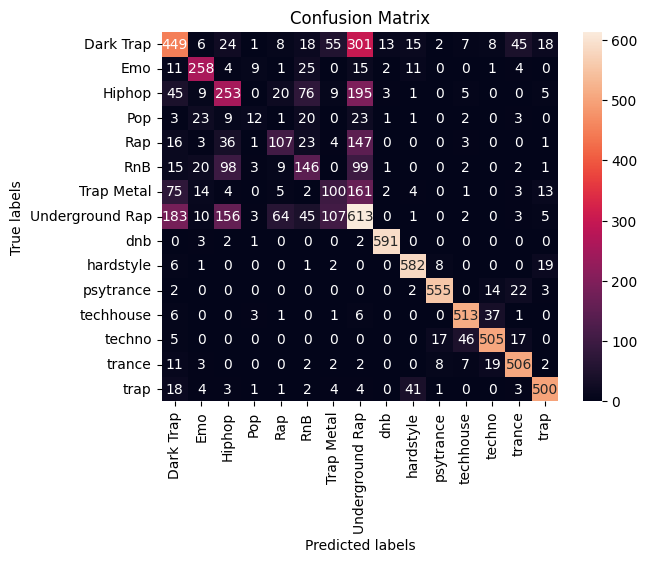

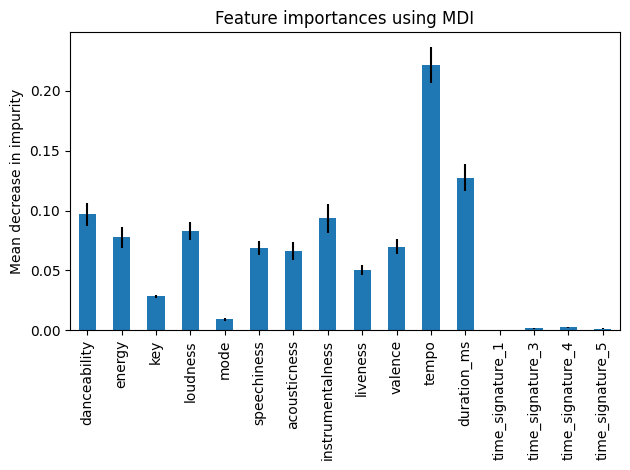

In [ ]:
random_forest_clf(features, labels)

features_no_anomalies, labels_no_anomalies = delete_anomalies(features, labels)
random_forest_clf(features_no_anomalies, labels_no_anomalies)

## Cohesion and Separation

### Cohesion

In [ ]:
unique_labels = sorted(list(set(list(labels))))

In [ ]:
rel_cohesion = dict()
# Calculate the cohesion (similarity) between points in each genre.
for genre in unique_labels:
    # Sum WSS over each genre.
    cohesion = 0
    data = df[df['genre'] == genre].drop('genre', axis=1)
    centroid = np.mean(data, axis=0)
    for i in range(0, len(data)):
        # Sum WSS over each data point in current cluster.
        record = data.iloc[i, :]
        cohesion += (math.sqrt(((record[0] - centroid[0]) ** 2) + (record[1] - centroid[1]) ** 2)) ** 2
    print("The cohesion of records in %s is %f." % (genre, cohesion))
    print("The cohesion of records in %s, relative to size, is %f.\n" % (genre, (cohesion / len(data))))
    rel_cohesion[genre] = cohesion / len(data)

In [ ]:
rel_cohesion

{'Dark Trap': 0.058601342870381504,
 'Emo': 0.06441904945691598,
 'Hiphop': 0.04657972775998981,
 'Pop': 0.03826215687861433,
 'Rap': 0.035171535867428876,
 'RnB': 0.04679084652903292,
 'Trap Metal': 0.059048882882951445,
 'Underground Rap': 0.04075715799548758,
 'dnb': 0.020946823874215682,
 'hardstyle': 0.016684909533313745,
 'psytrance': 0.016255905353177925,
 'techhouse': 0.022788032741416536,
 'techno': 0.02764761989696421,
 'trance': 0.0219659301105259,
 'trap': 0.026163920405677152}

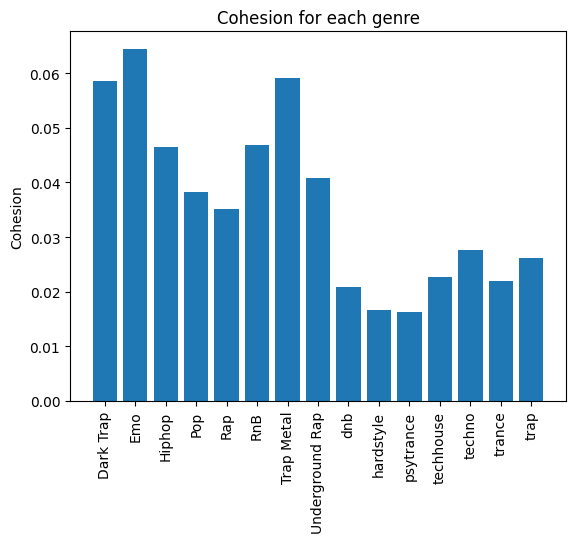

In [ ]:
x = list(rel_cohesion.keys())
y = list(rel_cohesion.values())

# Create the bar plot
plt.bar(x, y)

# Add labels and title
plt.xticks(rotation=90)
plt.ylabel('Cohesion')
plt.title('Cohesion for each genre')

# Show the plot
plt.show()

### Separation

In [ ]:
overall_centroid = np.mean(features, axis=0)
overall_centroid

danceability             0.639364
energy                   0.762516
key                      5.370240
loudness                -6.465442
mode                     0.549462
speechiness              0.136561
acousticness             0.096160
instrumentalness         0.283048
liveness                 0.214079
valence                  0.357101
tempo                  147.474056
duration_ms         250865.846685
time_signature_1         0.003546
time_signature_3         0.028815
time_signature_4         0.955608
time_signature_5         0.012032
dtype: float64

In [ ]:
print(unique_labels)

['Dark Trap', 'Emo', 'Hiphop', 'Pop', 'Rap', 'RnB', 'Trap Metal', 'Underground Rap', 'dnb', 'hardstyle', 'psytrance', 'techhouse', 'techno', 'trance', 'trap']


Dark Trap
18261633772454.723
Emo
1779790877144.6108
Hiphop
1589519710986.1597
Pop
718292940270.643
Rap
4232668585991.0605
RnB
1256160668609.0688
Trap Metal
21022297591083.844
Underground Rap
32794661091140.35
dnb
3776535560746.19
hardstyle
1341111546675.887
psytrance
112256780987345.36
techhouse
4958602637767.551
techno
65097041523518.01
trance
4027506625279.2915
trap
1971563172904.7822


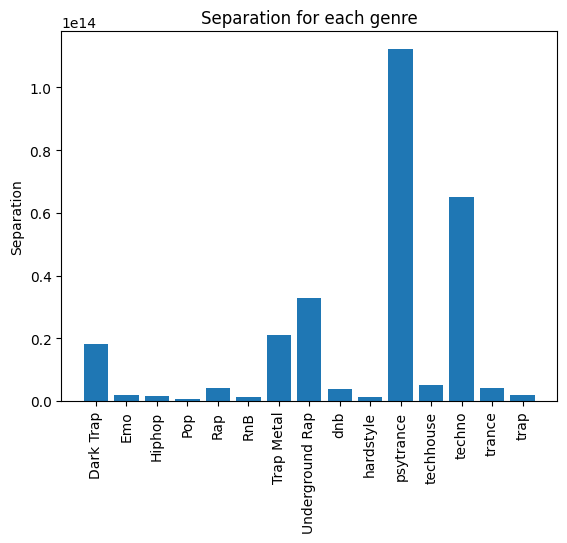

In [ ]:
separation_stats = dict()

centroid_dict = dict()

for genre in unique_labels:
    data = df[df['genre'] == genre].drop('genre', axis=1)
    
    centroid_dict[genre] = np.mean(data, axis=0)
    
    crnt_centroid = np.mean(data, axis=0)
    dist = math.dist(overall_centroid, crnt_centroid) ** 2
    
    data_size = len(data)
    
    bss = dist * data_size
    
    print(genre)
    print(bss)
    
    separation_stats[genre] = bss
    
x = list(separation_stats.keys())
y = list(separation_stats.values())

# Create the bar plot
plt.bar(x, y)

# Add labels and title
plt.xticks(rotation=90)
plt.ylabel('Separation')
plt.title('Separation for each genre')

# Show the plot
plt.show()